In [6]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout, Input, Add, ZeroPadding2D, Conv2D, \
    BatchNormalization, MaxPooling2D, Flatten, AveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from keras.applications import ResNet50


In [7]:
# Set the data path and categories
train_data_path = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/train'
test_data_path = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/test'
val_data_path = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/val'

categories = os.listdir(train_data_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))

img_size = 128
train_data = []
train_label = []
test_data = []
test_label = []
val_data = []
val_label = []

# Load the training images and labels
for category in categories:
    folder_path = os.path.join(train_data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            train_data.append(resized)
            train_label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

# Load the testing images and labels
for category in categories:
    folder_path = os.path.join(test_data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            test_data.append(resized)
            test_label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

# Load the validation images and labels
for category in categories:
    folder_path = os.path.join(val_data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            val_data.append(resized)
            val_label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

In [8]:
# Convert the data and labels to numpy arrays
train_data = np.array(train_data) / 255.0
train_data_rgb = np.repeat(train_data[..., np.newaxis], 3, -1)
train_label = np.array(train_label)
train_label = np_utils.to_categorical(train_label)

test_data = np.array(test_data) / 255.0
test_data_rgb = np.repeat(test_data[..., np.newaxis], 3, -1)
test_label = np.array(test_label)
test_label = np_utils.to_categorical(test_label)

val_data = np.array(val_data) / 255.0
val_data_rgb = np.repeat(val_data[..., np.newaxis], 3, -1)
val_label = np.array(val_label)
val_label = np_utils.to_categorical(val_label)

# Define the data generator for training
datagen_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = datagen_train.flow(train_data_rgb, train_label, batch_size=28)

In [9]:
# Define the modified ResNet34 model
def identity_block(X, f, filters):
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, s=2):
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

input_shape = (img_size, img_size, 3)

X_input = Input(input_shape)

X = ZeroPadding2D((3, 3))(X_input)

X = Conv2D(64, (7, 7), strides=(2, 2))(X)
X = BatchNormalization(axis=3)(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
X = identity_block(X, 3, [64, 64, 256])
X = identity_block(X, 3, [64, 64, 256])

X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
X = identity_block(X, 3, [128, 128, 512])
X = identity_block(X, 3, [128, 128, 512])
X = identity_block(X, 3, [128, 128, 512])

X = AveragePooling2D((2, 2), padding='same')(X)

X = Flatten()(X)
X = Dense(512, activation='relu')(X)
X = Dropout(0.5)(X)
X = Dense(len(categories), activation='softmax')(X)

model = Model(inputs=X_input, outputs=X)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('/kaggle/working/best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True,
                             mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
# Train the model
history = model.fit(train_generator, steps_per_epoch=len(train_data) // 32, epochs=50, validation_data=(val_data_rgb, val_label),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
180/180 [==============================] - ETA: 0s - loss: 2.2573 - accuracy: 0.3226
Epoch 1: val_accuracy improved from -inf to 0.39709, saving model to /kaggle/working/best_model.h5
180/180 [==============================] - 38s 148ms/step - loss: 2.2573 - accuracy: 0.3226 - val_loss: 1.4550 - val_accuracy: 0.3971
Epoch 2/50
180/180 [==============================] - ETA: 0s - loss: 1.4690 - accuracy: 0.3788
Epoch 2: val_accuracy did not improve from 0.39709
180/180 [==============================] - 23s 129ms/step - loss: 1.4690 - accuracy: 0.3788 - val_loss: 1.4503 - val_accuracy: 0.3971
Epoch 3/50
180/180 [==============================] - ETA: 0s - loss: 1.4664 - accuracy: 0.3893
Epoch 3: val_accuracy did not improve from 0.39709
180/180 [==============================] - 24s 132ms/step - loss: 1.4664 - accuracy: 0.3893 - val_loss: 1.4204 - val_accuracy: 0.3971
Epoch 4/50
180/180 [==============================] - ETA: 0s - loss: 1.4595 - accuracy: 0.3945
Epoch 4: val_

In [12]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data_rgb, test_label, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)




Test Loss: 1.4111534357070923
Test Accuracy: 0.385869562625885


In [13]:
# Load the best model
model.load_weights('/kaggle/working/best_model.h5')

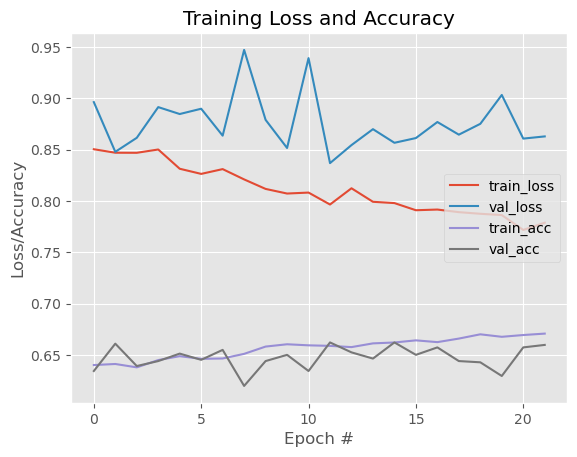

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data_rgb, test_label, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [15]:
# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(test_data_rgb, test_label, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

# Get the predictions for the test set
predictions = model.predict(test_data_rgb)
predicted_labels = np.argmax(predictions, axis=-1)

# Generate the classification report
report = classification_report(np.argmax(test_label, axis=1), predicted_labels)
print(report)

Test loss: 0.7750527262687683
Test accuracy: 0.6696860194206238
52/52 [==============================] - 2s 47ms/step
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       447
           1       0.64      0.94      0.76       639
           2       0.86      0.74      0.80       223
           3       0.30      0.04      0.07       296
           4       0.84      0.82      0.83        51

    accuracy                           0.67      1656
   macro avg       0.66      0.64      0.62      1656
weighted avg       0.62      0.67      0.62      1656



<Figure size 640x480 with 0 Axes>

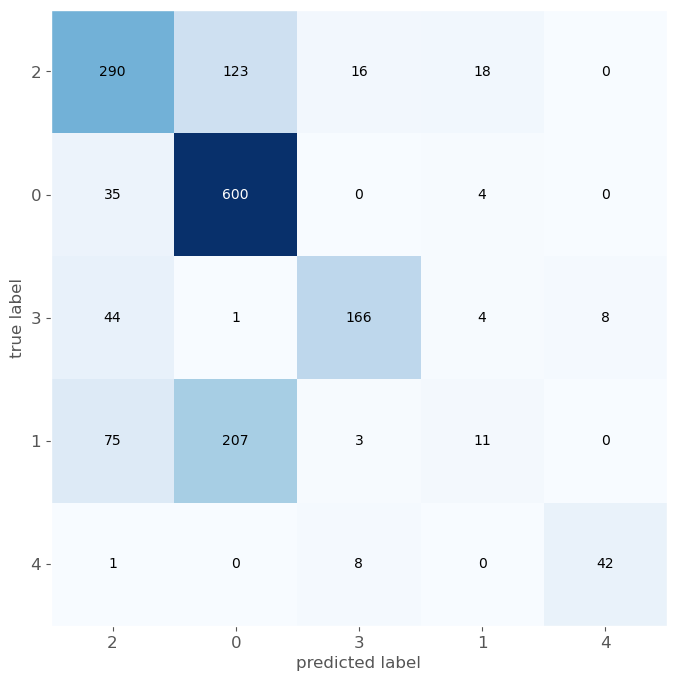

In [16]:
# Plot the confusion matrix
test_labels = np.argmax(test_label, axis=1)
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(len(categories)), categories, fontsize=12)
plt.yticks(range(len(categories)), categories, fontsize=12)
plt.show()

1/1 [==============================] - 0s 21ms/step
A.I predicts: 0
Correct prediction for label 0 is 2


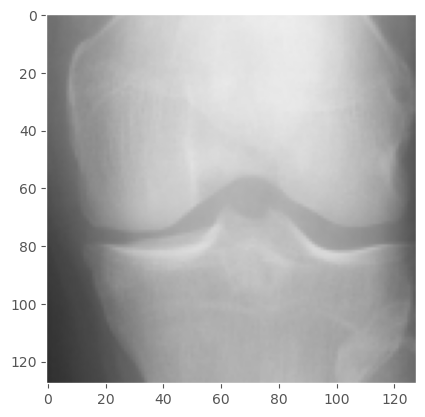

In [20]:
# Select a single image from the test set for prediction
X = 38
img_single = test_data_rgb[X]
img_single = cv2.resize(img_single, (img_size, img_size))
img_single = np.expand_dims(img_single, 0)

# Make prediction on the single image
predictions_single = model.predict(img_single)
print('A.I predicts:', categories[np.argmax(predictions_single)])
print("Correct prediction for label", np.argmax(test_label[X]), 'is', categories[np.argmax(test_label[X])])

# Display the single image
plt.imshow(np.squeeze(img_single))
plt.grid(False)
plt.show()
